# Spiking Fourier transform (S-FT) basic example

This notebook will show the main features of the spikingFT library. The examples are meant to illustrate the structure of the simulation and how the SNN dynamics work for the spiking DFT. For getting quantitative error values of the S-FT, execute the script `run_sft.py`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import run_sft

## Create and set up a simualtion handler

The simulation configuration is stored in the form of a dictionary. On the example scripts, the configuration is read from json files. For the sake of clarity, in this notebook we create the configuration directly in the code. The meaning of the different configuration parameters is the following:

* sim_time: Simulation time of each of the spiking stages involved. Each layer in the SNN contains two stages, silent and spiking
* time_step: Time elapsed on each simulation step. NOTE: This value can only be `1` for simulations in Loihi
* mode: FT mode of operation. It can be "fft" or "dft"
* current_decay: Internal parameter for the current decay in Loihi. It should always be zero
* samples_per_chirp: Amount of samples contained on each chirp of the radar frame
* chirps_per_frame: Amount of chirps that will be taken from the radar frame. With the default radar data, can take a maximum value of `4`
* antennas: Number of antennas taken into consideration. With the default radar data, it can only be `1`
* nframes: Number of frames taken into consideration. With the default radar data, it can only be `1`

The S-DFT shows a good performance for the default configuration shown in the next snipped. However, it does not necessarily work for all possible configurations, as it is a proof-of-concept and many situations have not been tested. This is specially the case when running it in Loihi, as the chip has limitations in terms of maximum threshold voltage, voltage resolution, and other relevant variables.

Important note: When running the SNN in Loihi, make sure that the SIM_TIME and N_SAMPLES parameters are correctly defined in the `setBias.c` script. This is a limitation in the NxSDK library from Intel that requires a fix that is out of the scope of the SpikingFT library.

In [2]:
datapath = pathlib.Path("../data/TI_radar/special_cases").resolve()

config = {
    "snn_config": {
        "sim_time": 150,
        "time_step": 1,
        "mode": "dft",
        "framework": "numpy",
        "current_decay": 0,
    },
    "data": {
        "samples_per_chirp": 256,
        "chirps_per_frame": 1,
        "antennas": 1,
        "nframes": 1
    }
    
}

We create now an instance of the simulation handler class `SimHandler`. The simulation handler is the entry point to the simulation of the SNN, and will store all of the variables, data, and parameters that are required for simulating the network. The configuration will be defined by the dictionary created before

In [3]:
import spikingFT.startup
sim_handler = spikingFT.startup.run(datapath, config, autorun=False)

The output of the simulation is centered around zero, so it shows the time relative to the middle of the simulation time. Therefore, positive spike times represent positive values, and negative spike times respresent negative values. The original spiking times are stored in the variable `sim_handler.snn.spikes`. Later on this tutorial, we will plot this times as well.

If running in Loihi, this step may take some time

In [4]:
sim_handler.run()
real_spikes = sim_handler.output[:, 0]
imag_spikes = sim_handler.output[:, 1]

Extract the real and imaginary components of the S-FT output. The modulus is calculated as the L2-norm of these two components. For visualization purposes, we change the result of the modulus to a logarithmic scale

In [5]:
nsamples = config["data"]["samples_per_chirp"]
# Remove offset bin and negative spectrum. They do not contain relevant information
sft_real = real_spikes[1:int(nsamples/2)]
sft_imag = imag_spikes[1:int(nsamples/2)]
# Normalize between -1 and 1
sft_max = np.max(np.abs(np.hstack([sft_real, sft_imag])))
sft_real = real_spikes / sft_max
sft_imag = imag_spikes / sft_max
sft_modulus = np.sqrt(sft_real**2 + sft_imag**2)
sft_modulus = np.log10(9*sft_modulus/sft_modulus.max()+1)

In [6]:
data = sim_handler.raw_data[0, 0, :]
norm_data = data - data.min()
norm_data /= norm_data.max()
norm_data = (norm_data-0.5) * 2
ft_np = np.fft.fft(norm_data) / (nsamples/2)
ft_real = ft_np.real[1:int(nsamples/2)]
ft_imag = ft_np.imag[1:int(nsamples/2)]
ft_modulus = np.abs(ft_np)[1:int(nsamples/2)]

Text(0.5, 1.0, 'NumPy FFT')

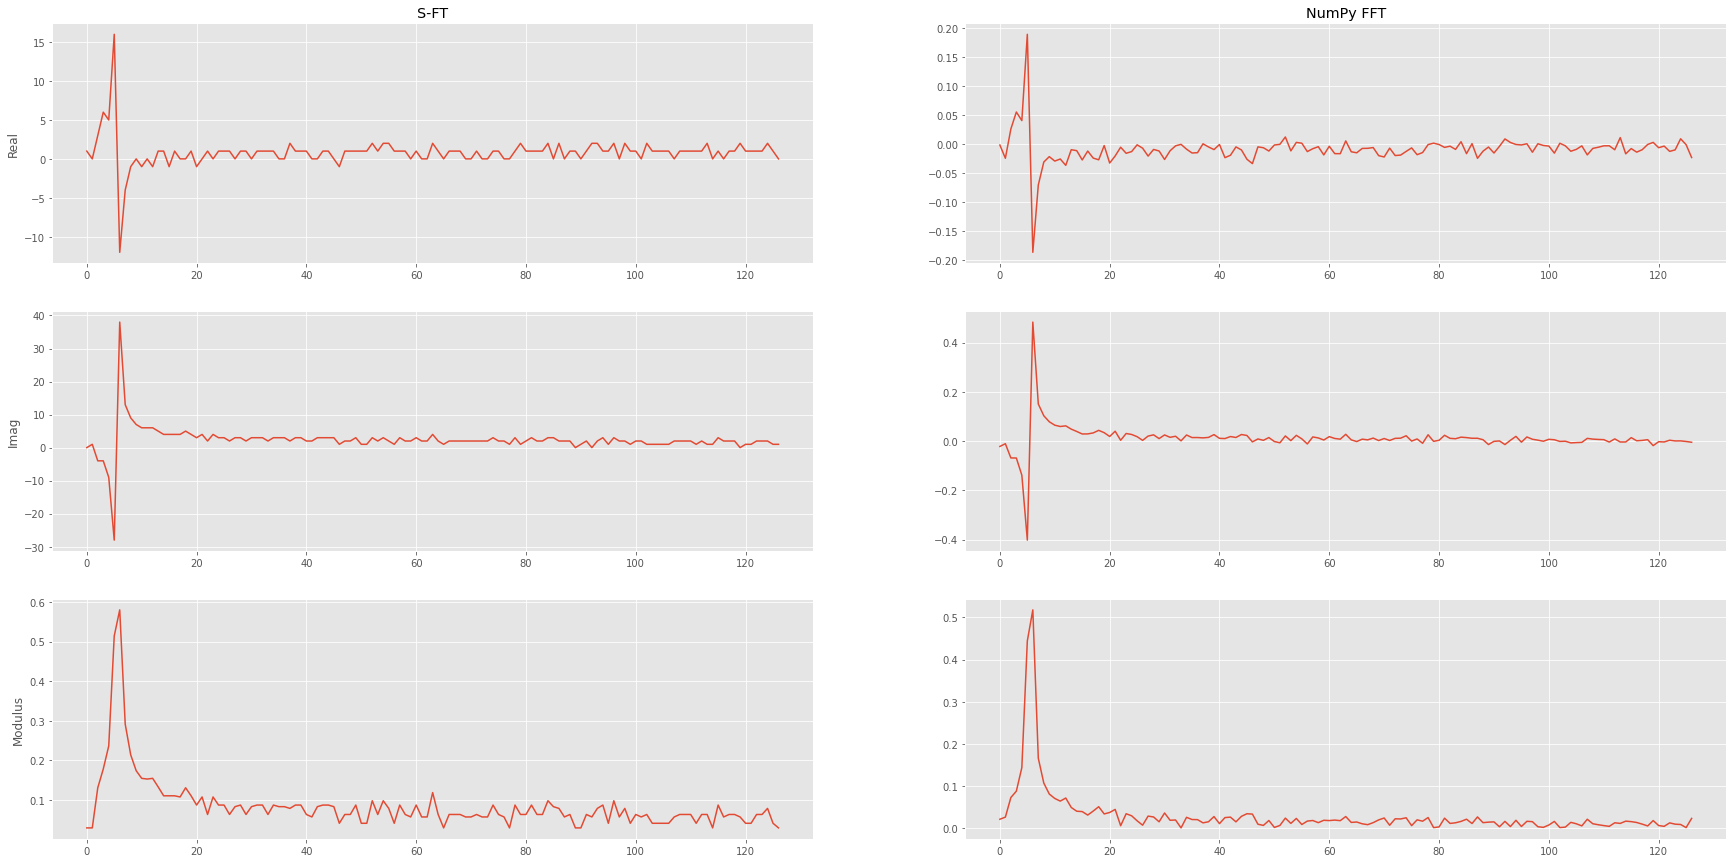

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (30, 15))
axes[0,0].plot(real_spikes[1:128])
axes[0,0].set_ylabel("Real")
axes[1,0].plot(imag_spikes[1:128])
axes[1,0].set_ylabel("Imag")
axes[2,0].plot(sft_modulus[1:128])
axes[2,0].set_ylabel("Modulus")
axes[0,0].set_title("S-FT")

axes[0,1].plot(ft_real)
axes[1,1].plot(ft_imag)
axes[2,1].plot(ft_modulus)
axes[0,1].set_title("NumPy FFT")

## Plot neuronal dynamics

We will plot next the dynamics of the voltage and spike times for all the neurons involved in the simulation.

In the plot, it is very easy to observe a breaking point at half the simulation time. This indicates the change from the _silent stage_ to the _spiking stage_. Throughout the second stage, the membrane voltage of the neurons is charged with a constant current that provokes a spike at a time proportional to the voltage at the end of the _silent stage_.

The scatter plot with the spiking times show two clusters of spikes. The first half belongs to neurons that represents the real values of the FT, whereas the second half belongs to neurons that represent imaginary values. The spikes at the half time of the second stage represent zero values, spikes that happen earlier represent positive values, and spikes that happen later represent negative values. It is easy to notice that there is a big accumulation of spikes around zero, which is the expected result from the FFT plot in the figures run before


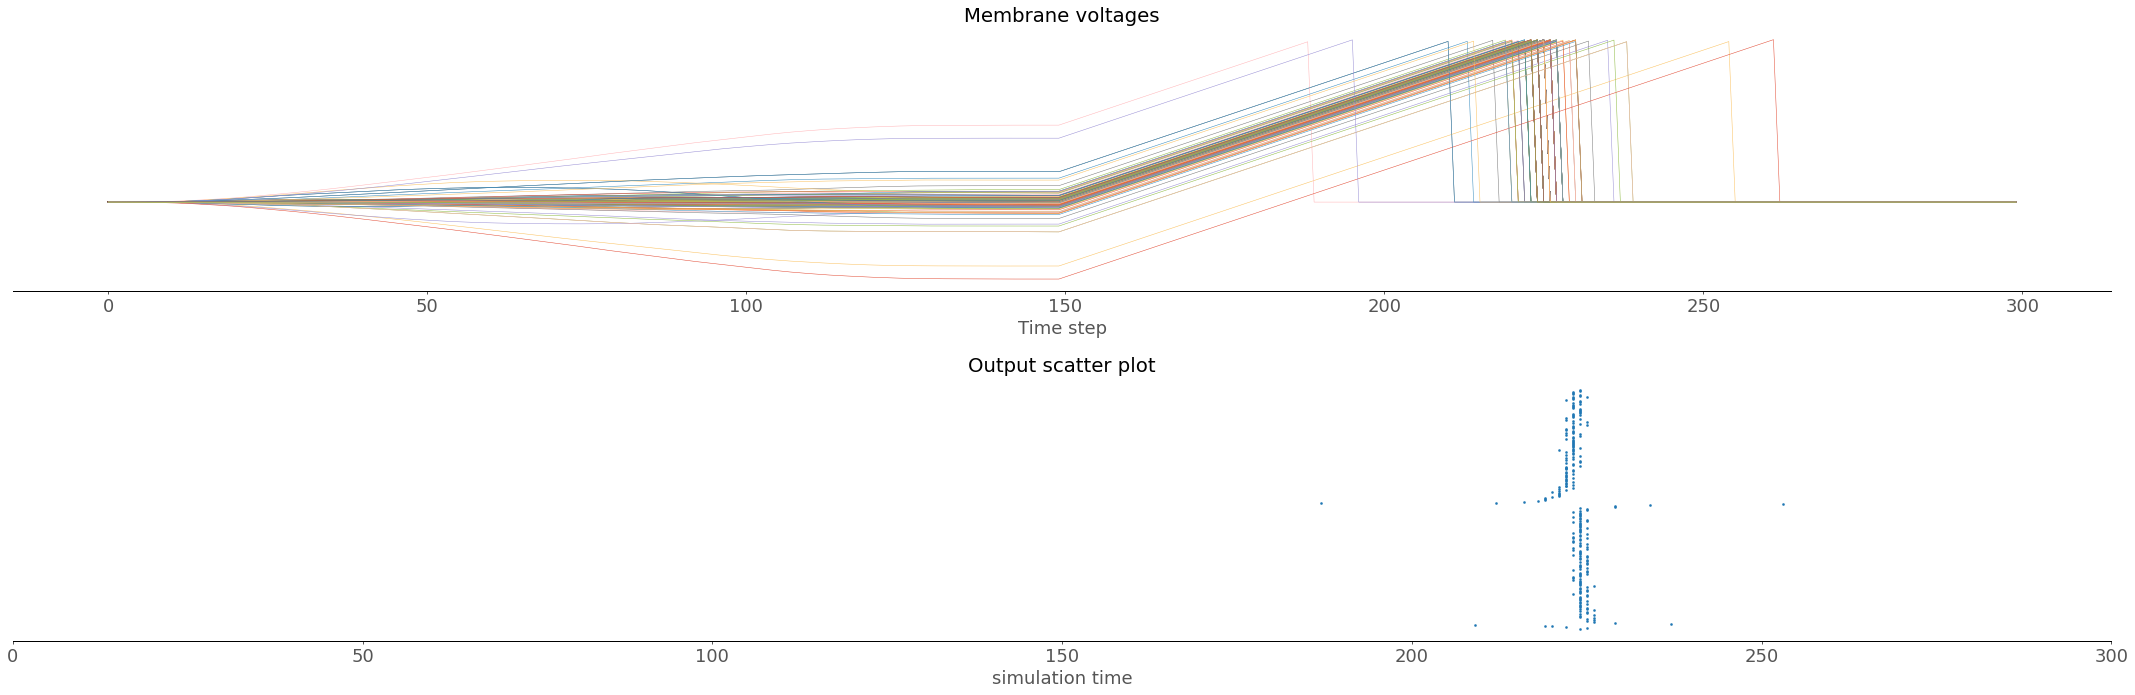

In [8]:
sim_time = config["snn_config"]["sim_time"]
spikes = sim_handler.snn.spikes
voltage = sim_handler.snn.voltage
real = spikes[:, 0][1:int(nsamples/2)]
imag = spikes[:, 1][1:int(nsamples/2)]

# Plot S-FT result and reference result
kwargs = {}
kwargs["plot_names"] = ["voltages", "spikes"]
kwargs["data"] = [
voltage,
(real, imag, 2*sim_time),
]
sim_plotter = spikingFT.utils.plotter.SNNSimulationPlotter(**kwargs)
plt.rcParams['figure.figsize'] = [30, 10]
fig = sim_plotter()
